# Fooling LIME and SHAP
## New Datasets (5)

Find at least two further (tabular) datasets with a risk of discrimination (that are not mentioned in the paper and study the impact of fooling on them.

Gender discrimination dataset: https://www.kaggle.com/hjmjerry/gender-discrimination

In [1]:
import os

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from fooling_LIME_SHAP_Interface.adversarial_model_toolbox import AdversarialModelToolbox
from fooling_LIME_SHAP_Interface.util.explainer_type import ExplainerType
from fooling_LIME_SHAP_Interface.util.ml_type import MLType

First we define all the neccessary variables.

In [2]:
TRAIN_TEST_SPLIT = 0.2
SEED = 666

dataset_name = 'heart_failure_clinical_records_dataset'
input_ids = list(range(1, 12))
categorical_input_ids = [1, 3, 5, 9, 10]
output_id = 12
biased_id = 9  # sex

categorical_input_ids = [input_ids.index(cat_id) for cat_id in categorical_input_ids]
biased_id = input_ids.index(biased_id)

Loading the dataset and doing some preprocessing. There are two datasets. One Dataset is with the biased feature and the other dataset is unbiased because all rows from the biased feature are set to 0.

In [3]:
# Load dataset
lawsuit_df = pd.read_csv(os.path.join("datasets", dataset_name + ".csv"))
lawsuit_df = lawsuit_df.fillna(0)

# Split input and output
y_df = lawsuit_df.iloc[:, output_id]
x_df = lawsuit_df.iloc[:, input_ids]

scaler = MinMaxScaler()
scaler.fit(x_df.to_numpy())
x = scaler.transform(x_df.to_numpy())

for idx in categorical_input_ids:
    x[idx] = x_df.iloc[idx]
    le = LabelEncoder()
    x[idx] = le.fit_transform(x[idx])

# Create train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y_df.to_numpy(), test_size=TRAIN_TEST_SPLIT, random_state=SEED)

# Create training data without biased column
ux_train = x_train.copy()
ux_train[:, biased_id] = 0
ux_test = x_test.copy()
ux_test[:, biased_id] = 0

Train the biased and unbiased ML model

In [4]:
biased_ml = RandomForestClassifier(random_state=SEED)
biased_ml.fit(x_train, y_train)
print("Accuracy of biased model: {0:3.2}".format(biased_ml.score(x_test, y_test)))

Accuracy of biased model: 0.87


In [5]:
unbiased_ml = RandomForestClassifier(random_state=SEED)
unbiased_ml.fit(ux_test, y_test)
print("Accuracy of unbiased model: {0:3.2}".format(unbiased_ml.score(ux_test, y_test)))

Accuracy of unbiased model: 1.0


## Get LIME Explanations

In [6]:
adv = AdversarialModelToolbox(biased_model=biased_ml,
                              x_train=x_train, 
                              y_train=y_train, 
                              x_test=x_test, 
                              y_test=y_test,
                              input_feature_names=lawsuit_df.columns[input_ids].tolist(),
                              categorical_feature_indices=categorical_input_ids,
                              unbiased_model=unbiased_ml,
                              biased_id=biased_id, 
                              fool_explainer_type=ExplainerType.LIME,
                              ml_type=MLType.CLASSIFICATION_BINARY, 
                              seed=SEED)
adv.train()
adv.get_explanations(explanation_sample_number=-1)

Calculating Lime explanations
Original Lime explanation:
{'time': -0.10327270050858105, 'serum_creatinine': 0.08220965862264616, 'creatinine_phosphokinase': 0.05475271170078247, 'ejection_fraction': -0.031550919110416076, 'sex=1': -0.01602783340205546, 'smoking=1': -0.007682336506873935, 'diabetes=0': 0.008417482043900278, 'serum_sodium': 0.006268712114660829, 'platelets': -0.003914210813546234, 'anaemia=1': -7.422473652627318e-05, 'high_blood_pressure=0': 0.0021700643203369776, 'sex=0': 0.00439217133172201, 'smoking=0': 0.013585784922426144, 'anaemia=0': 0.00039003480282771104, 'high_blood_pressure=1': -0.0014479487457968415, 'diabetes=1': -0.0049990193939403165}
Adversarial Lime explanation:
{'serum_sodium': -0.08945500109635024, 'time': -0.089649751760586, 'ejection_fraction': -0.046671548110624725, 'anaemia=1': 0.01434908516492543, 'diabetes=0': -0.015631522576313537, 'platelets': -0.015738868865763693, 'serum_creatinine': -0.016778918474257023, 'smoking=1': -0.0027332428102050453,

## Get SHAP Explanations

Calculating Shap explanations


  0%|          | 0/59 [00:00<?, ?it/s]

Original Shap explanation:


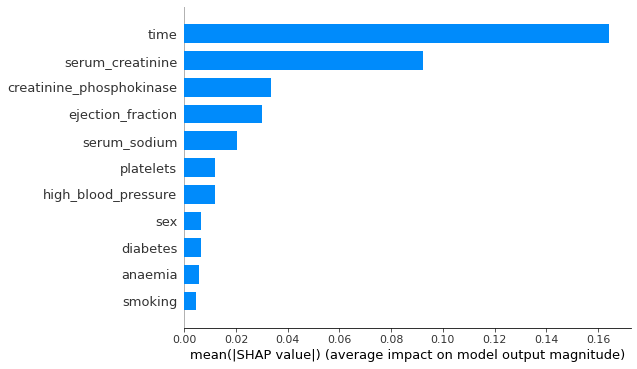

  0%|          | 0/59 [00:00<?, ?it/s]

Adversarial Shap explanation:


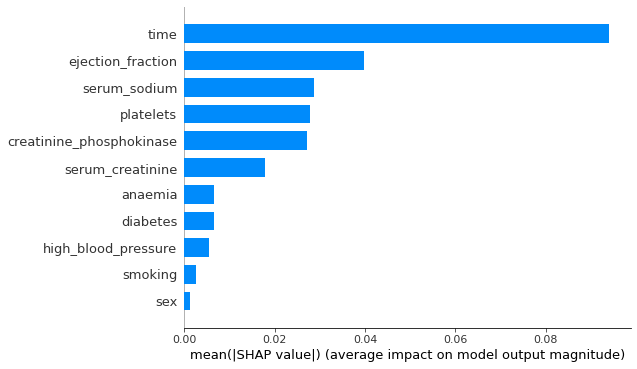

Prediction fidelity between original and adversarial model: 0.92


In [7]:
adv = AdversarialModelToolbox(biased_model=biased_ml, 
                              x_train=x_train, 
                              y_train=y_train,
                              x_test=x_test,
                              y_test=y_test,
                              input_feature_names=lawsuit_df.columns[input_ids].tolist(),
                              categorical_feature_indices=categorical_input_ids,
                              unbiased_model=unbiased_ml,
                              biased_id=biased_id,
                              fool_explainer_type=ExplainerType.SHAP,
                              ml_type=MLType.CLASSIFICATION_BINARY,
                              seed=SEED)
adv.train()
adv.get_explanations(explanation_sample_number=-1)

## Get PDP Explanations

Calculating PDP explanations
Original PDP explanation:


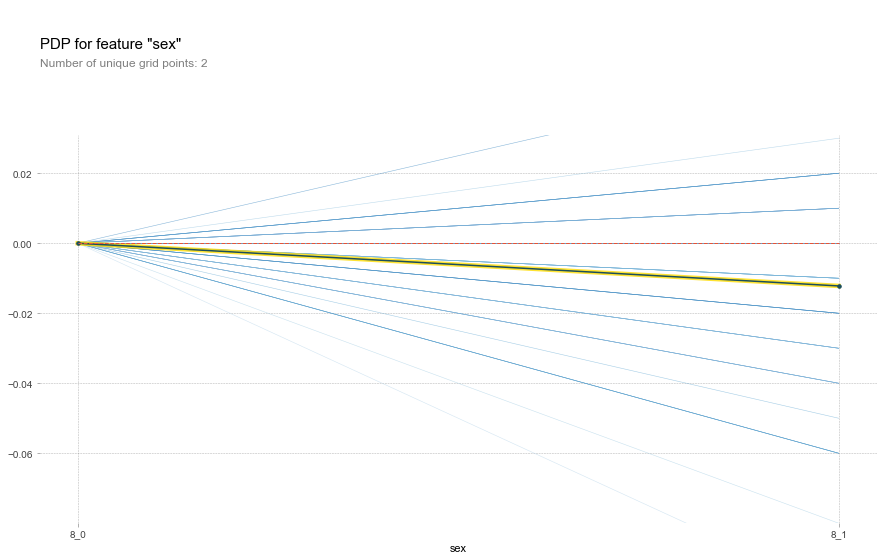

Adversarial PDP explanation:


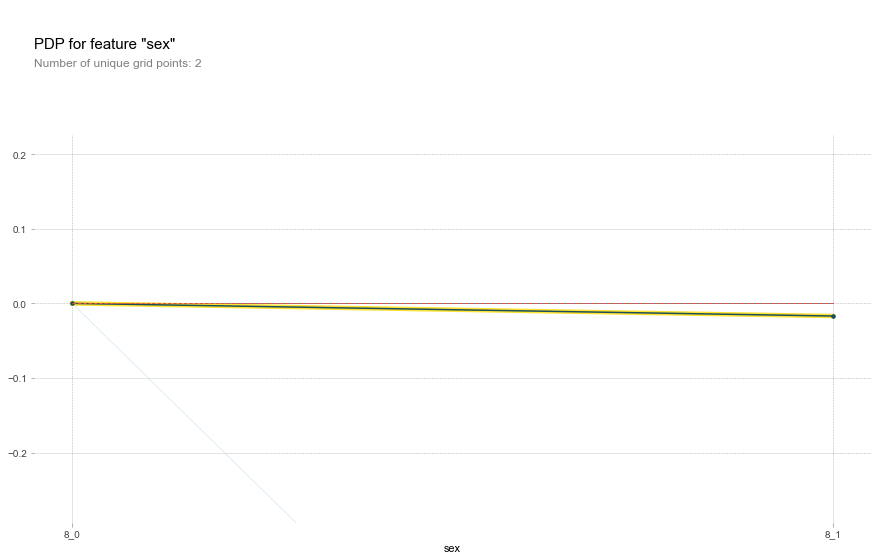

Prediction fidelity between original and adversarial model: 0.93


In [8]:
adv = AdversarialModelToolbox(biased_model=biased_ml,
                              x_train=x_train, 
                              y_train=y_train,
                              x_test=x_test,
                              y_test=y_test,
                              input_feature_names=lawsuit_df.columns[input_ids].tolist(),
                              categorical_feature_indices=categorical_input_ids,
                              unbiased_model=unbiased_ml,
                              biased_id=biased_id, 
                              fool_explainer_type=ExplainerType.PDP,
                              ml_type=MLType.CLASSIFICATION_BINARY,
                              seed=SEED)
adv.train()
adv.get_explanations(explanation_sample_number=-1)